<a href="https://colab.research.google.com/github/Mc4minta/AIB5-PcapAttackClassifier/blob/main/EvaluateBaselinePacket_Benign_Normal_Other.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# list pcap zip
import os
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
for file in files:
  print(file)

DoS.zip
DDoS.zip
PortScan.zip
Benign.zip
DoS-HTTP-Flood.zip
Benign2.zip
DoS-overall.zip
DoS-Layer3and4.zip
FTP-Bruteforce.zip
SSH-Bruteforce.zip
DoS-Slow-Rate.zip


In [3]:
# list each attack folder without '.zip' and append to attacks[]
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
attacks = []
for file in files:
  attacks.append(file[:-4])
for attack in attacks:
  print(attack)

DoS
DDoS
PortScan
Benign
DoS-HTTP-Flood
Benign2
DoS-overall
DoS-Layer3and4
FTP-Bruteforce
SSH-Bruteforce
DoS-Slow-Rate


In [4]:
# define function to unzip(attack.zip)
import zipfile

def unzip_attack_zip(attack):
  pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
  if(attack[-4:]=='.zip'):
    zip_file_name = attack
  else:
    zip_file_name = attack + '.zip'
  zip_file_path = os.path.join(pcap_zip_dir, zip_file_name)
  destination_directory = '/content/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_directory)
    print(f"'{zip_file_name}' unzipped to '{destination_directory}'.")
  except Exception as e:
      print(f"Error : {e}")

# unzip_attack_zip('DDoS')

In [5]:
attacks = ['Benign']

In [6]:
# iterate through each attack .zip and unzip it
for attack in attacks:
  print(f"Processing {attack}...")
  if(attack not in os.listdir('/content/')):
    unzip_attack_zip(attack)
  else:
    print(f"{attack} already unzipped")

Processing Benign...
'Benign.zip' unzipped to '/content/'.


In [7]:
# clear unused file
for attack in attacks:
  pcap_dir = f'/content/{attack}'
  flow_dir = f'/content/{attack}_csv'
  files = os.listdir(pcap_dir)
  for file in files:
    file_name = file[:-5]
    if 'normal_' in file_name:
      os.remove(f'{pcap_dir}/{file_name}.pcap')

In [20]:
# list all pcap file in each attack

for attack in attacks:
  print('--------------------------------')
  print(f"PCAP for {attack}")
  print('--------------------------------')
  attack_pcaps = os.listdir(f'/content/{attack}')
  for attack_pcap in attack_pcaps:
    if attack_pcap[-5:] != '.pcap':
      os.remove(f'/content/{attack}/{attack_pcap}')
    else:
      print(attack_pcap)

--------------------------------
PCAP for Benign
--------------------------------
DoS-GoldenEye_benign.pcap
Normal-h3_10.pcap
Normal-h3_2.pcap
Normal-h3_3.pcap
Normal-h3_1.pcap
Normal-h3_8.pcap
Normal-h3_5.pcap
DoS-Hulk_benign.pcap
Normal-h3_12.pcap
Normal-h3_11.pcap
Normal-h3_9.pcap
Normal-h3_4.pcap
Normal-h3_6.pcap


# Prediction setup (speed run)

In [9]:
!pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.9 MB/s eta 0:00:00


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scapy.all import PcapReader, IP, TCP
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()

# Load tokenizer and model once (replace model path with your model)
tokenizer = AutoTokenizer.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload")
model = AutoModelForSequenceClassification.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload").to(device)
model.eval()

classes = [
    'Analysis', 'Backdoor', 'Bot', 'DDoS', 'DoS', 'DoS GoldenEye', 'DoS Hulk',
    'DoS SlowHTTPTest', 'DoS Slowloris', 'Exploits', 'FTP Patator', 'Fuzzers',
    'Generic', 'Heartbleed', 'Infiltration', 'Normal', 'Port Scan',
    'Reconnaissance', 'SSH Patator', 'Shellcode', 'Web Attack - Brute Force',
    'Web Attack - SQL Injection', 'Web Attack - XSS', 'Worms'
]

classes_mapping = {
    'Analysis': 'Other', 'Backdoor': 'Other', 'Bot': 'Other', 'DDoS': 'Other',
    'DoS': 'DoS', 'DoS GoldenEye': 'DoS-HTTP-Flood', 'DoS Hulk': 'DoS-HTTP-Flood',
    'DoS SlowHTTPTest': 'DoS-Slow-Rate', 'DoS Slowloris': 'DoS-Slow-Rate',
    'Exploits': 'Other', 'FTP Patator': 'FTP-Bruteforce', 'Fuzzers': 'Other',
    'Generic': 'Other', 'Heartbleed': 'Other', 'Infiltration': 'Other',
    'Normal': 'Benign', 'Port Scan': 'PortScan', 'Reconnaissance': 'Other',
    'SSH Patator': 'SSH-Bruteforce', 'Shellcode': 'Other',
    'Web Attack - Brute Force': 'Other', 'Web Attack - SQL Injection': 'Other',
    'Web Attack - XSS': 'Other', 'Worms': 'Other',
}

packets_brief = {}

def processing_packet_conversion(packet):
    packet_2 = packet
    protocol_counts = {}
    protocols = []

    while packet_2:
        layer = packet_2[0]
        protocol_counts[layer.name] = protocol_counts.get(layer.name, 0) + 1
        protocols.append(layer.name)

        if not layer.payload:
            break
        packet_2 = layer.payload

    src_ip = packet[IP].src
    dst_ip = packet[IP].dst
    src_port = packet.sport
    dst_port = packet.dport
    ip_length = len(packet[IP])
    ip_ttl = packet[IP].ttl
    ip_tos = packet[IP].tos
    tcp_data_offset = packet[TCP].dataofs
    tcp_flags = packet[TCP].flags

    payload_bytes = bytes(packet.payload)
    payload_length = len(payload_bytes)
    payload_decimal = ' '.join(str(byte) for byte in payload_bytes)

    final_data = (
        "0 0 195 -1 "
        f"{src_port} {dst_port} {ip_length} {payload_length} "
        f"{ip_ttl} {ip_tos} {tcp_data_offset} {int(tcp_flags)} -1 {payload_decimal}"
    )
    return final_data

def create_results_dataframe(predictions):
    df = pd.DataFrame({
        'Packet_Indices': list(range(len(predictions))),
        'Predicted_Attack': [classes[p] for p in predictions]
    })
    df['Result'] = df['Predicted_Attack'].map(classes_mapping)
    return df

def batch_predict_pcap(file_path, batch_size=32, filter_bytes=None):
    global model

    texts = []
    packets_nbr = 0

    with PcapReader(file_path) as pcap:
        for pkt in pcap:
            if IP in pkt and TCP in pkt:
                payload_bytes = bytes(pkt.payload)
                if filter_bytes is None or filter_bytes in payload_bytes:
                    text = processing_packet_conversion(pkt)
                    if text:
                        texts.append(text[:1024])  # truncate to 1024 chars
                        packets_nbr += 1

    print(f"Collected {packets_nbr} TCP/IPv4 packets matching filter")

    if not texts:
        print("No packets to process.")
        return pd.DataFrame()  # Return empty dataframe if no data

    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    if use_fp16:
        model = model.half()

    all_preds = []
    packets_brief.clear()  # Clear previous counts

    for batch in loader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if use_fp16:
            attention_mask = attention_mask.half()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().tolist()

            for pred in preds:
                pred_class = classes[pred]
                if pred_class != "Normal":
                    packets_brief[pred_class] = packets_brief.get(pred_class, 0) + 1

            all_preds.extend(preds)

    # Print summary
    for attack, count in packets_brief.items():
        print(f"{attack}: {count}")

    # Plot results
    if packets_brief:
        keys = list(packets_brief.keys())
        vals = list(packets_brief.values())
        plt.bar(keys, vals)
        plt.xlabel('Attacks')
        plt.ylabel('Count')
        plt.title('Detected possible attacks')
        plt.show()
    else:
        print("No attacks detected.")

    # Return DataFrame with detailed predictions
    return create_results_dataframe(all_preds)


# Example usage:
# df_results = batch_predict_pcap("/content/bruteforce.pcap")
# print(df_results.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [11]:
for attack in attacks:
  print(f"Processing {attack}...")
  os.makedirs(f'/content/{attack}_prediction', exist_ok=True)

Processing Benign...


Processing Benign...
  Processing DoS-GoldenEye_benign.pcap...
Collected 1604 TCP/IPv4 packets matching filter


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

DoS GoldenEye: 527
Exploits: 1
DoS Hulk: 1


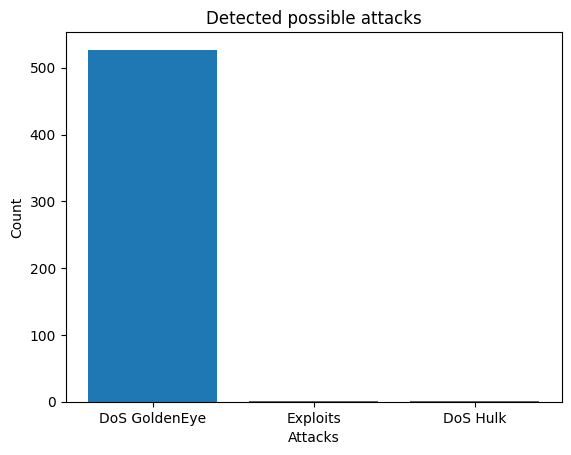

    Saved to /content/Benign_prediction/DoS-GoldenEye_benign_prediction.csv
  Processing Normal-h3_10.pcap...
Collected 98906 TCP/IPv4 packets matching filter
Bot: 19793
Generic: 1
Fuzzers: 1
DoS GoldenEye: 1


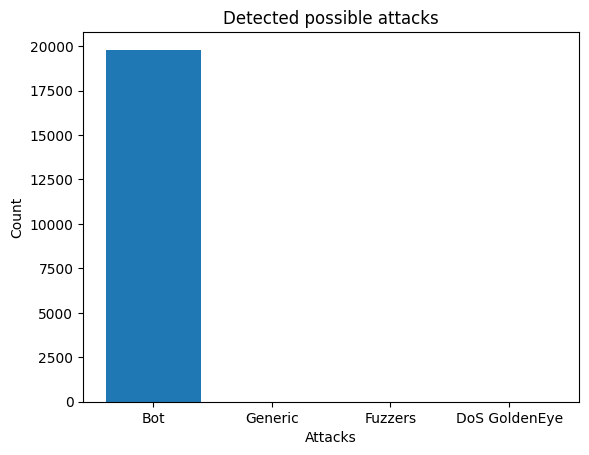

    Saved to /content/Benign_prediction/Normal-h3_10_prediction.csv
  Processing Normal-h3_2.pcap...
Collected 96988 TCP/IPv4 packets matching filter
Generic: 1
Bot: 33
Infiltration: 1


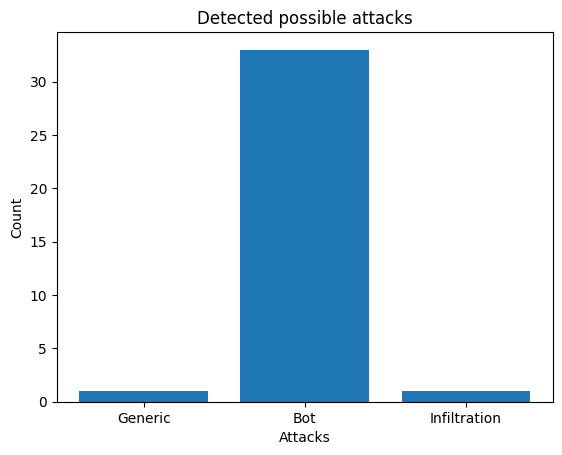

    Saved to /content/Benign_prediction/Normal-h3_2_prediction.csv
  Processing Normal-h3_3.pcap...
Collected 32187 TCP/IPv4 packets matching filter
Bot: 3
Generic: 1
DDoS: 1


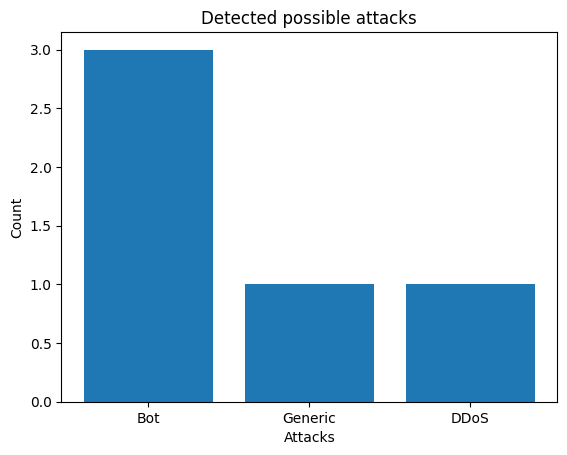

    Saved to /content/Benign_prediction/Normal-h3_3_prediction.csv
  Processing Normal-h3_1.pcap...
Collected 38269 TCP/IPv4 packets matching filter
Generic: 1
Bot: 5


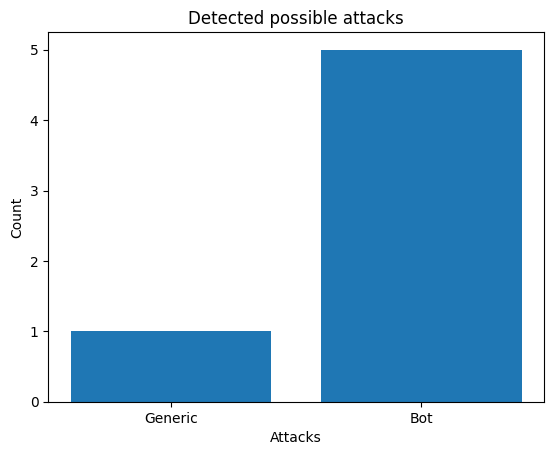

    Saved to /content/Benign_prediction/Normal-h3_1_prediction.csv
  Processing Normal-h3_8.pcap...
Collected 91938 TCP/IPv4 packets matching filter
Generic: 1
Bot: 14


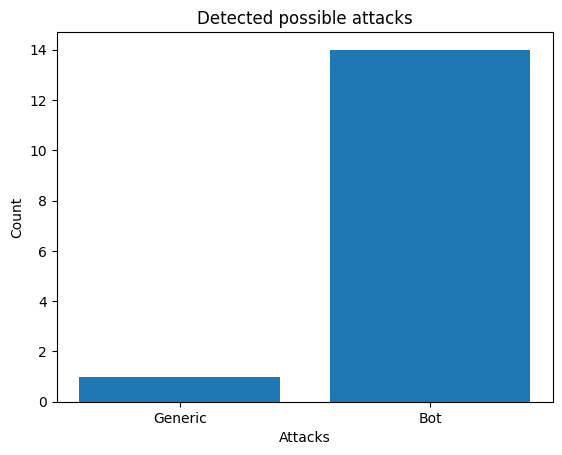

    Saved to /content/Benign_prediction/Normal-h3_8_prediction.csv
  Processing Normal-h3_5.pcap...
Collected 319060 TCP/IPv4 packets matching filter
Bot: 44
Infiltration: 1
Generic: 3949
Fuzzers: 2
DoS GoldenEye: 15273
DoS: 1
Heartbleed: 1
SSH Patator: 1


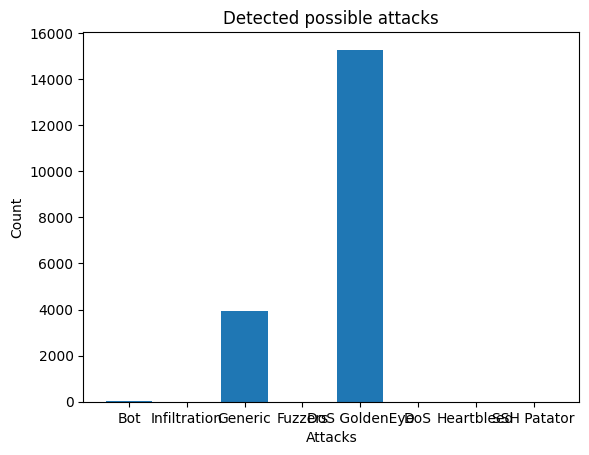

    Saved to /content/Benign_prediction/Normal-h3_5_prediction.csv
  Processing DoS-Hulk_benign.pcap...
Collected 1604 TCP/IPv4 packets matching filter
DoS GoldenEye: 527
Exploits: 1
DoS Hulk: 1


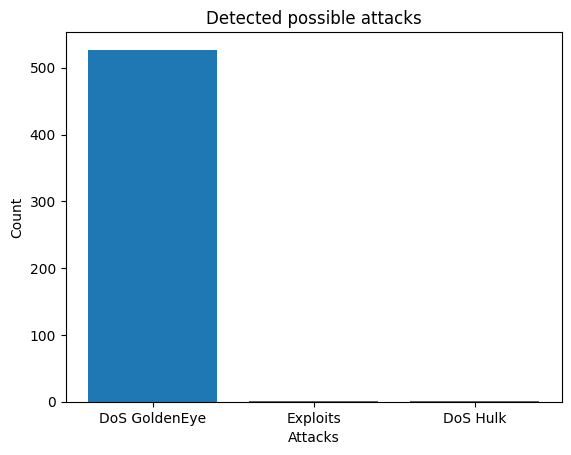

    Saved to /content/Benign_prediction/DoS-Hulk_benign_prediction.csv
  Processing Normal-h3_12.pcap...
Collected 294218 TCP/IPv4 packets matching filter
Bot: 36
Generic: 1


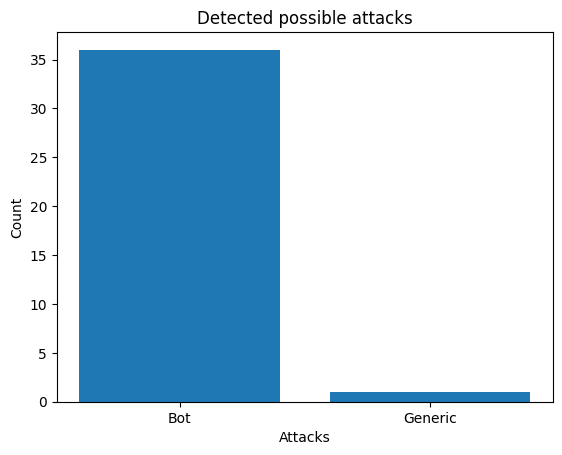

    Saved to /content/Benign_prediction/Normal-h3_12_prediction.csv
  Processing Normal-h3_11.pcap...
Collected 203655 TCP/IPv4 packets matching filter
Bot: 18
Infiltration: 1
DoS GoldenEye: 3
DoS: 1


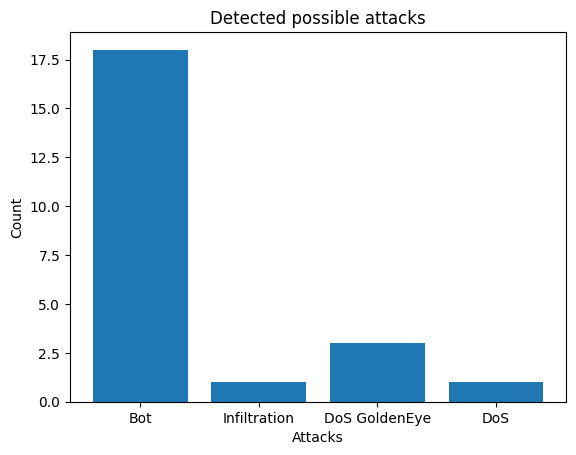

    Saved to /content/Benign_prediction/Normal-h3_11_prediction.csv
  Processing Normal-h3_9.pcap...
Collected 114890 TCP/IPv4 packets matching filter
Infiltration: 1
Bot: 5
Generic: 1


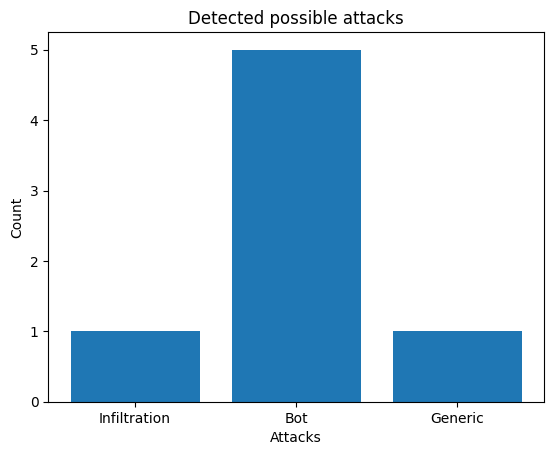

    Saved to /content/Benign_prediction/Normal-h3_9_prediction.csv
  Processing Normal-h3_4.pcap...
Collected 196476 TCP/IPv4 packets matching filter
Bot: 382
Fuzzers: 5
Infiltration: 1
SSH Patator: 44


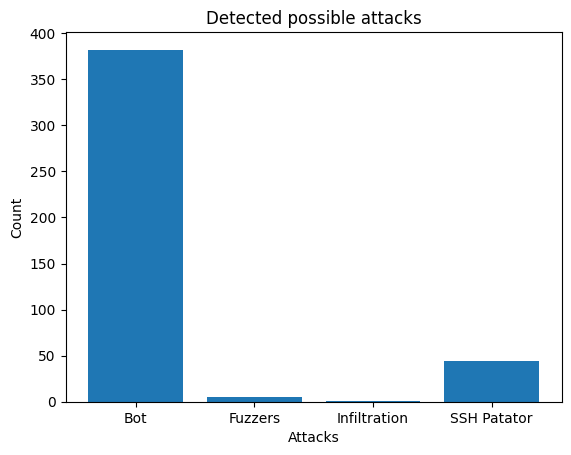

    Saved to /content/Benign_prediction/Normal-h3_4_prediction.csv
  Processing Normal-h3_6.pcap...
Collected 269536 TCP/IPv4 packets matching filter
Bot: 62
Generic: 53
SSH Patator: 5
Heartbleed: 1
DoS GoldenEye: 5
Web Attack - XSS: 1
Exploits: 1
Fuzzers: 3
Infiltration: 2
DoS: 3


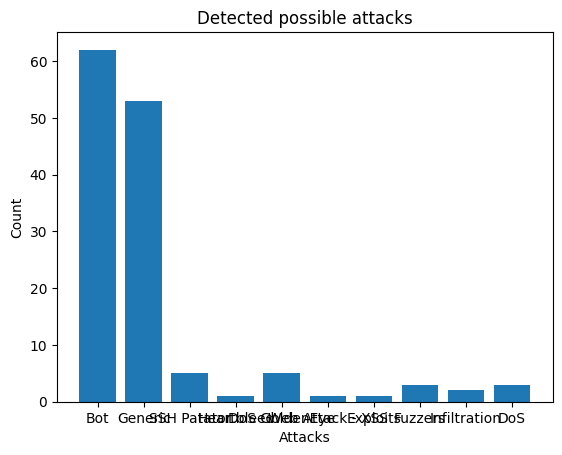

    Saved to /content/Benign_prediction/Normal-h3_6_prediction.csv


In [12]:
for attack in attacks:
  print(f"Processing {attack}...")
  files = os.listdir(f'/content/{attack}')
  for file in files:
    if not file.endswith('.pcap'):
        continue
    print(f"  Processing {file}...")

    prediction_file_name = file.replace('.pcap', '_prediction.csv')
    prediction_file_path = f'/content/{attack}_prediction/{prediction_file_name}'

    df_results = batch_predict_pcap(f'/content/{attack}/{file}', filter_bytes=b"")

    df_results.to_csv(prediction_file_path, index=False)
    print(f"    Saved to {prediction_file_path}")

In [13]:
# just seeing choosen_label value counts

import os
import pandas as pd

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    if not pcap_file.endswith('.pcap'):
        continue

    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    prediction_file_name = f'{file_name}_prediction.csv'
    prediction_file_dir = f'/content/{attack}_prediction/'
    prediction_file_path = f'{prediction_file_dir}/{prediction_file_name}'

    # Check if the prediction file exists and is not empty
    if os.path.exists(prediction_file_path) and os.path.getsize(prediction_file_path) > 0:
        try:
            df = pd.read_csv(prediction_file_path)
            print(f"Processing {pcap_file_name}")
            print('--')
            print(df['Result'].value_counts())
            print('--')
            print(df['Predicted_Attack'].value_counts())
        except Exception as e:
            print(f"Error reading or processing {prediction_file_name}: {e}")
    else:
        print(f"Prediction file not found or is empty: {prediction_file_name}")

Processing DoS-GoldenEye_benign.pcap
--
Result
Benign            1075
DoS-HTTP-Flood     528
Other                1
Name: count, dtype: int64
--
Predicted_Attack
Normal           1075
DoS GoldenEye     527
Exploits            1
DoS Hulk            1
Name: count, dtype: int64
Processing Normal-h3_10.pcap
--
Result
Benign            79110
Other             19795
DoS-HTTP-Flood        1
Name: count, dtype: int64
--
Predicted_Attack
Normal           79110
Bot              19793
Generic              1
Fuzzers              1
DoS GoldenEye        1
Name: count, dtype: int64
Processing Normal-h3_2.pcap
--
Result
Benign    96953
Other        35
Name: count, dtype: int64
--
Predicted_Attack
Normal          96953
Bot                33
Generic             1
Infiltration        1
Name: count, dtype: int64
Processing Normal-h3_3.pcap
--
Result
Benign    32182
Other         5
Name: count, dtype: int64
--
Predicted_Attack
Normal     32182
Bot            3
Generic        1
DDoS           1
Name: count,

In [14]:
# prompt: # prompt: modified the code that the attack result will stillb e for each attack but all will save to the Result folder with the file name of {attack}_resu def get_most_common_non_benign(df):
# #     """
# #     Finds the most frequent non-Benign label in the 'Result' column of a DataFrame.
# #     Returns 'Unknown' if no non-Benign labels are found.
# #     """
# #     non_benign_results = df[df['Result'] != 'Benign']['Result']
# #     if not non_benign_results.empty:
# #         return non_benign_results.mode()[0]
# #     else:
# #         return 'Unknown'
# # # Create a single empty dataframe for the overall result
# # overall_summary_df = pd.DataFrame(columns=['FileName', 'Result', 'Attack'])
# # # Create the single 'result' directory
# # result_dir = '/content/Result'
# # os.makedirs(result_dir, exist_ok=True)
# # # Iterate through each attack and its corresponding prediction files
# # for attack in attacks:
# #     print(f"Analyzing predictions for {attack}...")
# #     prediction_dir = f'/content/{attack}_prediction/'
# #     if os.path.exists(prediction_dir):
# #         prediction_files = os.listdir(prediction_dir)
# #         for pred_file in prediction_files:
# #             if pred_file.endswith('_prediction.csv'):
# #                 prediction_file_path = os.path.join(prediction_dir, pred_file)
# #                 try:
# #                     df_prediction = pd.read_csv(prediction_file_path)
# #                     # Get the most common non-Benign label
# #                     chosen_label = get_most_common_non_benign(df_prediction)
# #                     # Append the information to the overall summary dataframe
# #                     new_row = pd.DataFrame({
# #                         'FileName': [pred_file],
# #                         'Result': [chosen_label],
# #                         'Attack': [attack]  # This is the true label based on the folder name
# #                     })
# #                     overall_summary_df = pd.concat([overall_summary_df, new_row], ignore_index=True)
# #                     print

def get_most_common_non_benign(df):
  """
    Finds the most frequent non-Benign label in the 'Result' column of a DataFrame.
    Returns 'Unknown' if no non-Benign labels are found.
    """
  non_benign_results = df[df['Result'] != 'Benign']['Result']
  if not non_benign_results.empty:
    return non_benign_results.mode()[0]
  else:
    return 'Unknown'

# Create the single 'Result' directory
result_dir = '/content/Result'
os.makedirs(result_dir, exist_ok=True)

# Iterate through each attack and its corresponding prediction files
for attack in attacks:
  print(f"Analyzing predictions for {attack}...")
  prediction_dir = f'/content/{attack}_prediction/'
  if os.path.exists(prediction_dir):
    prediction_files = os.listdir(prediction_dir)
    # Create a dataframe for the current attack's results
    attack_summary_df = pd.DataFrame(columns=['FileName', 'Result', 'Attack'])
    for pred_file in prediction_files:
      if pred_file.endswith('_prediction.csv'):
        prediction_file_path = os.path.join(prediction_dir, pred_file)
        try:
          df_prediction = pd.read_csv(prediction_file_path)

          # Get the most common non-Benign label
          chosen_label = get_most_common_non_benign(df_prediction)

          # Append the information to the current attack's summary dataframe
          new_row = pd.DataFrame({
              'FileName': [pred_file],
              'Result': [chosen_label],
              'Attack': [attack]  # This is the true label based on the folder name
          })
          attack_summary_df = pd.concat(
              [attack_summary_df, new_row], ignore_index=True
          )

          print(
              f"  Processed {pred_file}: Most common non-Benign result is"
              f" '{chosen_label}'"
          )

        except Exception as e:
          print(f"  Error processing {pred_file}: {e}")

    # Save the current attack's summary dataframe to a CSV file in the 'Result' directory
    output_filename = f'{attack}_result.csv'
    output_path = os.path.join(result_dir, output_filename)
    attack_summary_df.to_csv(output_path, index=False)
    print(f"Saved summary for {attack} to {output_path}")

  else:
    print(f"  Prediction directory not found for {attack}: {prediction_dir}")

Analyzing predictions for Benign...
  Processed DoS-GoldenEye_benign_prediction.csv: Most common non-Benign result is 'DoS-HTTP-Flood'
  Processed Normal-h3_4_prediction.csv: Most common non-Benign result is 'Other'
  Processed DoS-Hulk_benign_prediction.csv: Most common non-Benign result is 'DoS-HTTP-Flood'
  Processed Normal-h3_1_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_9_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_12_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_6_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_3_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_11_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_8_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_2_prediction.csv: Most common non-Benign result is 'Other'
  Processed Normal-h3_5_prediction.csv: 

In [15]:
# prompt: generated sklearn classification result of each attack_result with y_test being Attack column and y_pred being Result column

from sklearn.metrics import classification_report

for attack in attacks:
  result_csv_path = f'/content/Result/{attack}_result.csv'
  if os.path.exists(result_csv_path):
    df_result = pd.read_csv(result_csv_path)

    y_true = df_result['Attack']
    y_pred = df_result['Result']

    print(f"Classification Report for {attack}:")
    print(classification_report(y_true, y_pred, zero_division=0)) # Use zero_division=0 to handle cases where a class has no predicted samples

  else:
    print(f"No result file found for {attack}.")
  print("-" * 40)

Classification Report for Benign:
                precision    recall  f1-score   support

        Benign       0.00      0.00      0.00      13.0
DoS-HTTP-Flood       0.00      0.00      0.00       0.0
         Other       0.00      0.00      0.00       0.0

      accuracy                           0.00      13.0
     macro avg       0.00      0.00      0.00      13.0
  weighted avg       0.00      0.00      0.00      13.0

----------------------------------------


In [16]:
from sklearn.metrics import classification_report

all_true_labels = []
all_predicted_labels = []

for attack in attacks:
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction/'
        prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'

        try:
            df_prediction = pd.read_csv(prediction_csv_path)
            # The true label for all packets in this file is the 'attack' name
            if attack != 'DoS-SlowRate':
                true_label = attack
            else:
                true_label = 'DoS-Slow-Rate'

            # Collect the predicted label for each packet from 'Chosen_Label'
            predicted_labels = df_prediction['Result'].tolist()

            # Extend our master lists
            all_true_labels.extend([true_label] * len(predicted_labels))
            all_predicted_labels.extend(predicted_labels)

        except FileNotFoundError:
            print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
        except Exception as e:
            print(f"Error processing prediction file {prediction_csv_path}: {e}")

# Now, print the classification report using the collected true and predicted labels
if all_true_labels and all_predicted_labels:
    print("\n--- Classification Report ---")
    # Ensure both lists are of the same length
    if len(all_true_labels) == len(all_predicted_labels):
        print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
    else:
        print("Error: Mismatch in the number of true labels and predicted labels.")
else:
    print("\nNo data collected to generate a classification report.")


--- Classification Report ---
                precision    recall  f1-score   support

        Benign       1.00      0.98      0.99   1759331
           DoS       0.00      0.00      0.00         0
DoS-HTTP-Flood       0.00      0.00      0.00         0
         Other       0.00      0.00      0.00         0
SSH-Bruteforce       0.00      0.00      0.00         0

      accuracy                           0.98   1759331
     macro avg       0.20      0.20      0.20   1759331
  weighted avg       1.00      0.98      0.99   1759331




--- Confusion Matrix ---
[[1718509       5   16338   24429      50]
 [      0       0       0       0       0]
 [      0       0       0       0       0]
 [      0       0       0       0       0]
 [      0       0       0       0       0]]


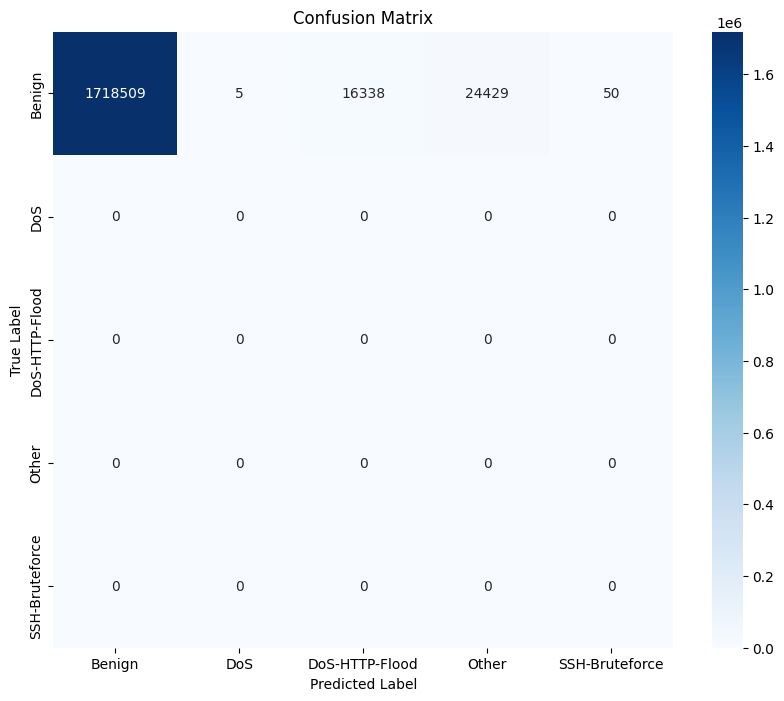

In [17]:
# prompt: do confusion matrix of the from sklearn.metrics import classification_report
# all_true_labels = []
# all_predicted_labels = []
# for attack in attacks:
#     pcap_files = os.listdir(f'/content/{attack}')
#     for pcap_file in pcap_files:
#         file_name = pcap_file.split('.')[0]
#         prediction_file_name = f'{file_name}_prediction.csv'
#         prediction_file_dir = f'/content/{attack}_prediction/'
#         prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'
#         try:
#             df_prediction = pd.read_csv(prediction_csv_path)
#             # The true label for all packets in this file is the 'attack' name
#             if attack != 'DoS-SlowRate':
#                 true_label = attack
#             else:
#                 true_label = 'DoS-Slow-Rate'
#             # Collect the predicted label for each packet from 'Chosen_Label'
#             predicted_labels = df_prediction['Chosen_Label'].tolist()
#             # Extend our master lists
#             all_true_labels.extend([true_label] * len(predicted_labels))
#             all_predicted_labels.extend(predicted_labels)
#         except FileNotFoundError:
#             print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
#         except Exception as e:
#             print(f"Error processing prediction file {prediction_csv_path}: {e}")
# # Now, print the classification report using the collected true and predicted labels
# if all_true_labels and all_predicted_labels:
#     print("\n--- Classification Report ---")
#     # Ensure both lists are of the same length
#     if len(all_true_labels) == len(all_predicted_labels):
#         print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
#     else:
#         print("Error: Mismatch in the number of true labels and predicted labels.")
# else:
#     print("\nNo data collected to generate a classification report.") too

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
# Ensure the unique labels are consistent across true and predicted lists
unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

if all_true_labels and all_predicted_labels and len(all_true_labels) == len(all_predicted_labels):
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=unique_labels)

    print("\n--- Confusion Matrix ---")
    print(cm)

    # Optional: Visualize the confusion matrix using seaborn and matplotlib
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nCannot generate Confusion Matrix: Mismatch in the number of true labels and predicted labels or no data collected.")



--- Confusion Matrix for DoS-GoldenEye_benign.pcap ---
[[1075  528    1]
 [   0    0    0]
 [   0    0    0]]


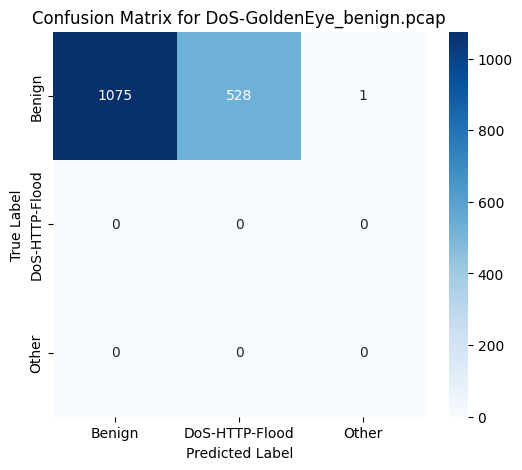


--- Confusion Matrix for Normal-h3_10.pcap ---
[[79110     1 19795]
 [    0     0     0]
 [    0     0     0]]


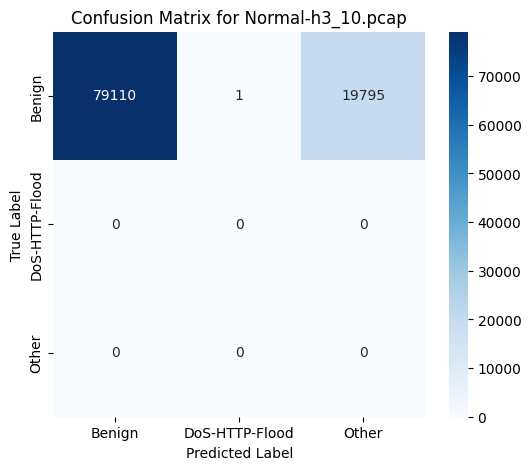


--- Confusion Matrix for Normal-h3_2.pcap ---
[[96953    35]
 [    0     0]]


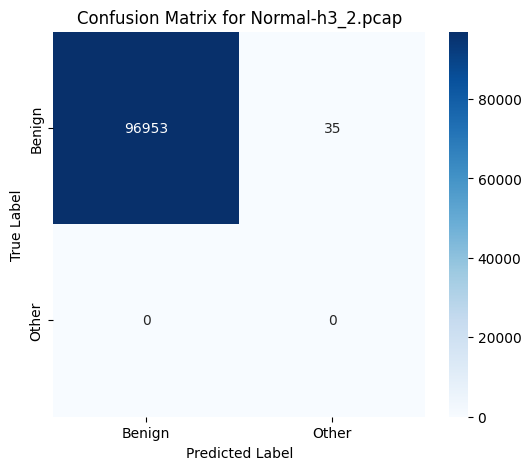


--- Confusion Matrix for Normal-h3_3.pcap ---
[[32182     5]
 [    0     0]]


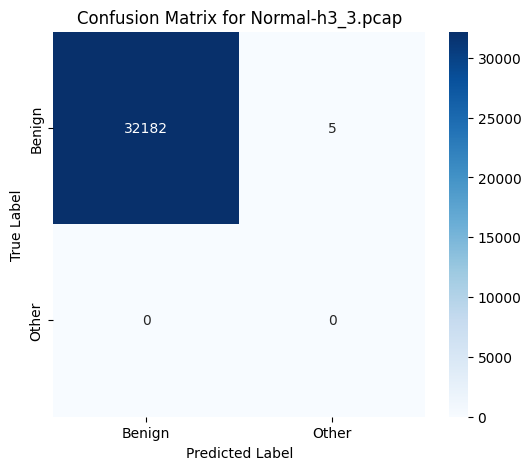


--- Confusion Matrix for Normal-h3_1.pcap ---
[[38263     6]
 [    0     0]]


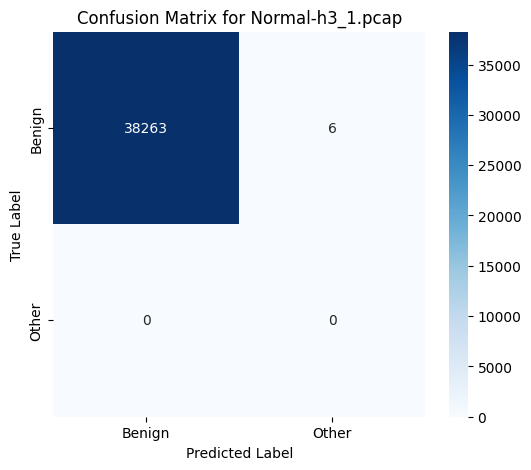


--- Confusion Matrix for Normal-h3_8.pcap ---
[[91923    15]
 [    0     0]]


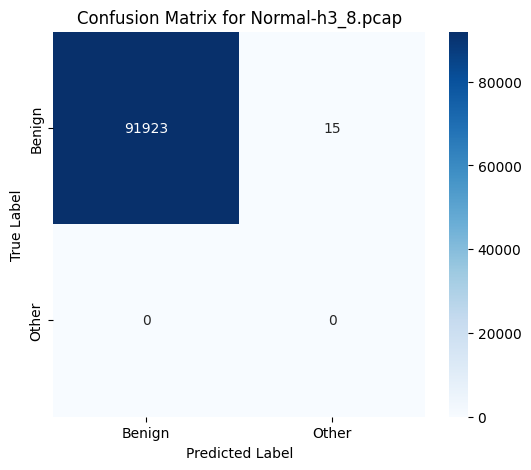


--- Confusion Matrix for Normal-h3_5.pcap ---
[[299788      1  15273   3997      1]
 [     0      0      0      0      0]
 [     0      0      0      0      0]
 [     0      0      0      0      0]
 [     0      0      0      0      0]]


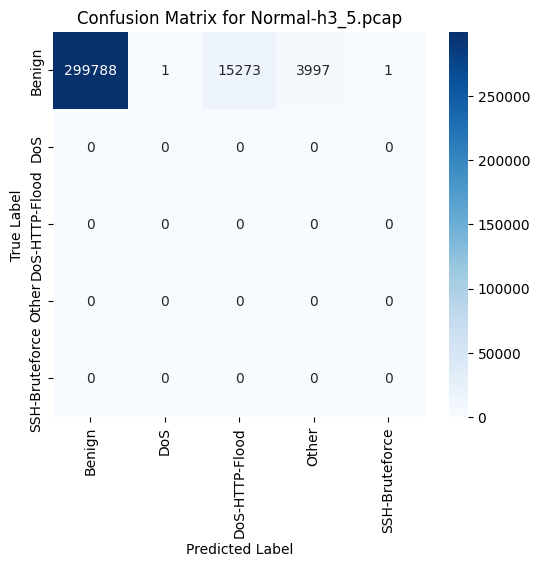


--- Confusion Matrix for DoS-Hulk_benign.pcap ---
[[1075  528    1]
 [   0    0    0]
 [   0    0    0]]


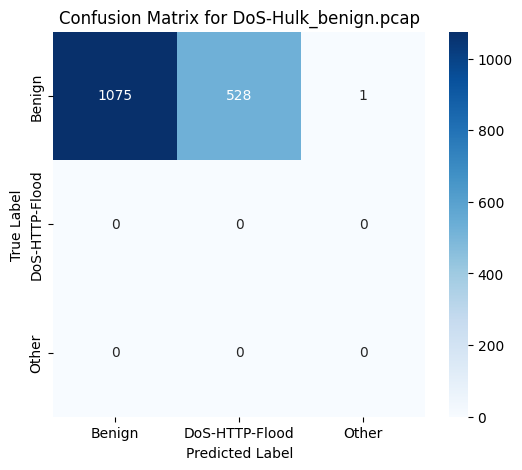


--- Confusion Matrix for Normal-h3_12.pcap ---
[[294181     37]
 [     0      0]]


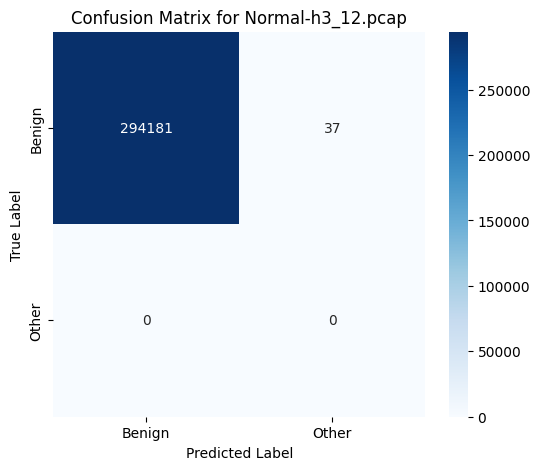


--- Confusion Matrix for Normal-h3_11.pcap ---
[[203632      1      3     19]
 [     0      0      0      0]
 [     0      0      0      0]
 [     0      0      0      0]]


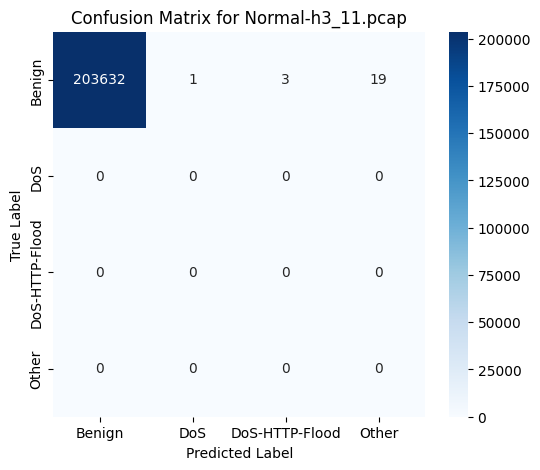


--- Confusion Matrix for Normal-h3_9.pcap ---
[[114883      7]
 [     0      0]]


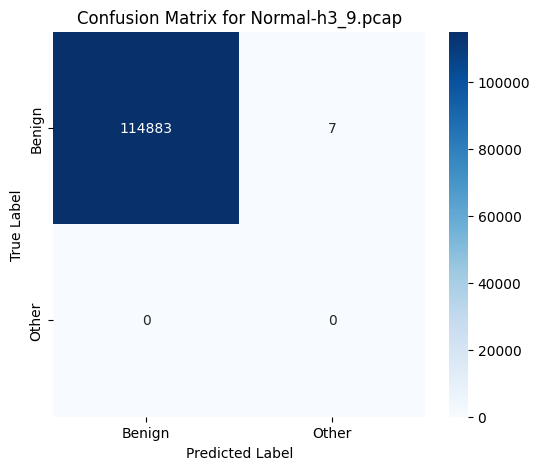


--- Confusion Matrix for Normal-h3_4.pcap ---
[[196044    388     44]
 [     0      0      0]
 [     0      0      0]]


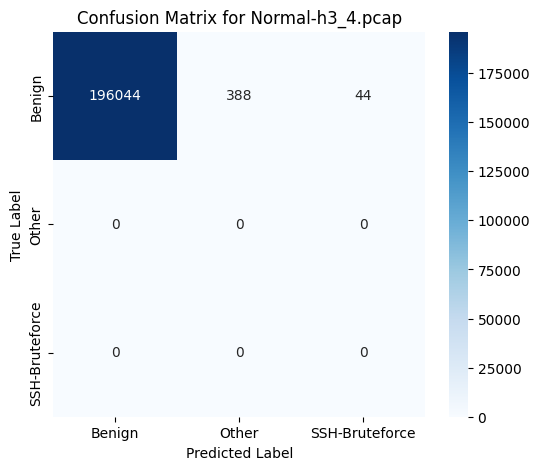


--- Confusion Matrix for Normal-h3_6.pcap ---
[[269400      3      5    123      5]
 [     0      0      0      0      0]
 [     0      0      0      0      0]
 [     0      0      0      0      0]
 [     0      0      0      0      0]]


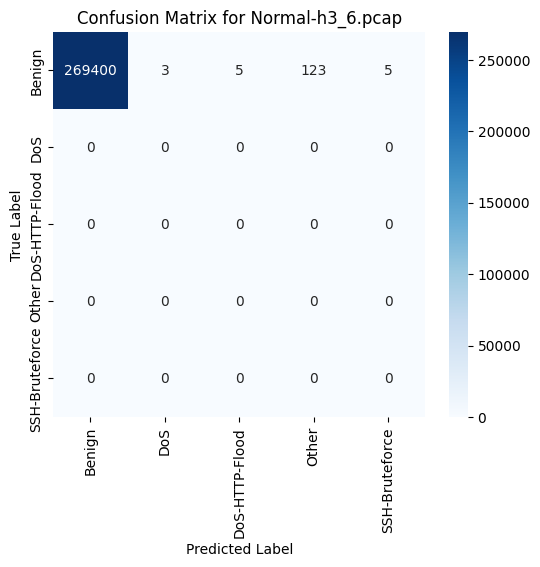

In [18]:

# prompt: print confsion matrix of each pcap file instead possible?
# # prompt: do confusion matrix of the from sklearn.metrics import classification_report
# # all_true_labels = []
# # all_predicted_labels = []
# # for attack in attacks:
# #     pcap_files = os.listdir(f'/content/{attack}')
# #     for pcap_file in pcap_files:
# #         file_name = pcap_file.split('.')[0]
# #         prediction_file_name = f'{file_name}_prediction.csv'
# #         prediction_file_dir = f'/content/{attack}_prediction/'
# #         prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'
# #         try:
# #             df_prediction = pd.read_csv(prediction_csv_path)
# #             # The true label for all packets in this file is the 'attack' name
# #             if attack != 'DoS-SlowRate':
# #                 true_label = attack
# #             else:
# #                 true_label = 'DoS-Slow-Rate'
# #             # Collect the predicted label for each packet from 'Chosen_Label'
# #             predicted_labels = df_prediction['Chosen_Label'].tolist()
# #             # Extend our master lists
# #             all_true_labels.extend([true_label] * len(predicted_labels))
# #             all_predicted_labels.extend(predicted_labels)
# #         except FileNotFoundError:
# #             print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
# #         except Exception as e:
# #             print(f"Error processing prediction file {prediction_csv_path}: {e}")
# # # Now, print the classification report using the collected true and predicted labels
# # if all_true_labels and all_predicted_labels:
# #     print("\n--- Classification Report ---")
# #     # Ensure both lists are of the same length
# #     if len(all_true_labels) == len(all_predicted_labels):
# #         print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
# #     else:
# #         print("Error: Mismatch in the number of true labels and predicted labels.")
# # else:
# #     print("\nNo data collected to generate a classification report.")

# Print confusion matrix for each pcap file
for attack in attacks:
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction/'
        prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'

        try:
            df_prediction = pd.read_csv(prediction_csv_path)

            # Determine the true label for this file
            if attack != 'DoS-SlowRate':
                true_label = attack
            else:
                true_label = 'DoS-Slow-Rate'

            # Extract true and predicted labels for this specific file
            true_labels_file = [true_label] * len(df_prediction)
            predicted_labels_file = df_prediction['Result'].tolist()

            print(f"\n--- Confusion Matrix for {pcap_file} ---")

            if true_labels_file and predicted_labels_file and len(true_labels_file) == len(predicted_labels_file):
                # Get all unique labels present in both true and predicted lists for this file
                unique_labels_file = sorted(list(set(true_labels_file + predicted_labels_file)))

                # Generate confusion matrix for this file
                cm_file = confusion_matrix(true_labels_file, predicted_labels_file, labels=unique_labels_file)
                print(cm_file)

                # Optional: Visualize the confusion matrix for this file
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm_file, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_file, yticklabels=unique_labels_file)
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.title(f'Confusion Matrix for {pcap_file}')
                plt.show()
            else:
                print(f"No valid data to generate confusion matrix for {pcap_file}.")

        except FileNotFoundError:
            print(f"\nPrediction file not found for {pcap_file}: {prediction_csv_path}")
        except Exception as e:
            print(f"\nError processing prediction file {prediction_csv_path}: {e}")




In [19]:
# prompt: print every result as dataframe display

from IPython.display import display

for attack in attacks:
    result_csv_path = f'/content/Result/{attack}_result.csv'
    if os.path.exists(result_csv_path):
        df_result = pd.read_csv(result_csv_path)
        print(f"\n--- Results for {attack} ---")
        print(df_result)
    else:
        print(f"\nNo result file found for {attack}.")
    print("-" * 40)


--- Results for Benign ---
                               FileName          Result  Attack
0   DoS-GoldenEye_benign_prediction.csv  DoS-HTTP-Flood  Benign
1            Normal-h3_4_prediction.csv           Other  Benign
2        DoS-Hulk_benign_prediction.csv  DoS-HTTP-Flood  Benign
3            Normal-h3_1_prediction.csv           Other  Benign
4            Normal-h3_9_prediction.csv           Other  Benign
5           Normal-h3_12_prediction.csv           Other  Benign
6            Normal-h3_6_prediction.csv           Other  Benign
7            Normal-h3_3_prediction.csv           Other  Benign
8           Normal-h3_11_prediction.csv           Other  Benign
9            Normal-h3_8_prediction.csv           Other  Benign
10           Normal-h3_2_prediction.csv           Other  Benign
11           Normal-h3_5_prediction.csv  DoS-HTTP-Flood  Benign
12          Normal-h3_10_prediction.csv           Other  Benign
----------------------------------------
